<a href="https://colab.research.google.com/github/danplotkin/DCGAN_PyTorch/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook I will be implementing a Deep Convolutional Generative Adversarial Network (DCGAN) based on the [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf) paper by Radford et. al. Unlike basic GANs, DCGANs incorporates deep convolutional neural networks (CNNs) in both the generator and discriminator. Let us look at a visualization of a DCGAN.

![image](https://raw.githubusercontent.com/danplotkin/DCGAN_PyTorch/main/DCGAN_architecture.png)

### Generator

The generator in a DCGAN is responsible for transforming random noise vectors into images. It takes in a random noise vector, denoted by $z$, which will follow a normal distribution. The main building block to the generator are transposed convolutional layers. These are also known as upsampling or deconvolutional layers. Every upsampling layer is followed by a Batch Normalization layer, and a ReLU activation function, except the last upsampling layer. After the last upsampling layer, the output is fed into the hyperbolic tangent (Tanh) which maps the output range to [-1, 1], which is what we want our pixel values for our image to be.

### Discriminator

The goal of the discriminator in a DCGAN it to discriminate between real and fake data samples created by the generator. The generator tries to generate samples that can fool the discriminator into classifying them as real. The discriminator takes in images channels as input. The building blocks to a discriminator are convolutional layers. Every convlutional layer is followed by a Batch Normalization layer and a Leaky ReLU except the first and last convolutional layers. The first convolutional layer is followed by a Leaky ReLU activation, with no Batch Normalization. The last convolutional layer is followed by a Sigmoid activation, mapping the output to a probability range of [0, 1].

### Network Interaction

The generator and discriminator interact with each other through an adversarial training process. The discriminator andd generator are first initialized with random weights. The generator will generate fake images with random noise vectors as input. These generated images will be fed as input into the discriminator. The discriminator will recieve both fake (from the generator) and real images (from the training data). It will learn to classify these as real or fake images. It does this through backpropagation. The loss from the discriminator is used as feedback to update the generator's weights.

# Import Libraries

In [17]:
import os
import random
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import torchvision.datasets as ds
import torchvision.utils as vutils

# Define Configurations

In [18]:
class Config:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  learning_rate = 2e-4
  batch_size = 128
  img_size = 64
  n_channels = 3
  z_dim = 100
  num_epochs = 10
  n_features = 64
  betas = (0.5, 0.999) # Defined in paper for Adam optimizer

# Preprocess Data

### Define Transformations

In [19]:
transforms = T.Compose(
  [
    T.ToTensor(),
    T.Resize((Config.img_size, Config.img_size)),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
  ]
)

### Create DataLoader

In [20]:
dataset = ds.CelebA(root="dataset/",
                    transform=transforms,
                    download=True)
data_loader = DataLoader(dataset, batch_size=Config.batch_size, shuffle=True)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


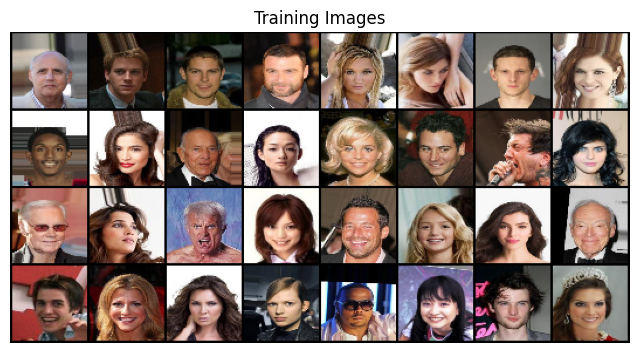

In [21]:
# Plot some training images
real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(Config.device)[:32], padding=2, normalize=True
            ).cpu(),(1,2,0)
    )
)
plt.show()

# Initlialize Weights

In [22]:
def initialize_weights(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

# Define Generator

In [23]:
class Generator(nn.Module):
  def __init__(self, z_dim, n_channels, n_features, hidden_dim=128):
    super(Generator, self).__init__()
    self.generator = nn.Sequential(
        self._block(z_dim, n_features*8, 4, 1, 0),
        self._block(n_features*8, n_features*4, 4, 2, 1),
        self._block(n_features*4, n_features*2, 4, 2, 1),
        self._block(n_features*2, n_features, 4, 2, 1),
        nn.ConvTranspose2d(n_features, n_channels, 4, 2, 1),
        nn.Tanh()
    )

  def forward(self, x):
    return self.generator(x)

  def _block(self,
             in_channels,
             out_channels,
             kernel_size,
             stride,
             padding,
             bias=False):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=bias
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

# Define Descriminator

In [24]:
class Discriminator(nn.Module):
  def __init__(self, n_channels, n_features):
    super(Discriminator, self).__init__()
    self.descriminator = nn.Sequential(
        nn.Conv2d(n_channels, n_features, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2),
        self._block(n_features, n_features*2, 4, 2, 1),
        self._block(n_features*2, n_features*4, 4, 2, 1),
        self._block(n_features*4, n_features*8, 4, 2, 1),
        nn.Conv2d(n_features*8, 1, 4, 1, 0),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.descriminator(x)

  def _block(self,
             in_channels,
             out_channels,
             kernel_size,
             stride, padding,
             bias=False):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=bias
        ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

### Define Parameters

In [25]:
# define models
gen = Generator(Config.z_dim, Config.n_channels, Config.n_features)\
  .to(Config.device)\
  .apply(initialize_weights)
disc = Discriminator(Config.n_channels, Config.n_features)\
  .to(Config.device)\
  .apply(initialize_weights)

# define optimizers
optim_gen = optim.Adam(gen.parameters(),
                       lr=Config.learning_rate,
                       betas=Config.betas)
optim_disc = optim.Adam(disc.parameters(),
                       lr=Config.learning_rate,
                       betas=Config.betas)

# define criterion
criterion = nn.BCELoss()

In [26]:
print(gen, '\n', '*'*50, '\n', disc)

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(64, 3, 

# Define Functional Class

We will create a class for our DCGAN than will train, generate images, and plot training image animations.

In [27]:
class DCGAN:
  def __init__(self,
               disc,
               gen,
               optim_disc,
               optim_gen,
               configs,
               dataloader,
               criterion):
    self.configs = configs
    self.data_loader = dataloader
    self.optim_gen = optim_gen
    self.optim_disc = optim_disc
    self.gen = gen
    self.disc = disc
    self.criterion = criterion
    self.img_list = []
    self.fixed_noise = torch.randn(32, Config.z_dim, 1, 1).to(Config.device)

  @torch.no_grad()
  def __call__(self, input_noise):
    self.gen.eval()
    return self.gen(input_noise).detach().cpu()

  def train(self):
    for epoch in range(self.configs.num_epochs):
      print(f'Epoch: {epoch+1}/{self.configs.num_epochs}')
      d_running_loss = 0.0
      g_running_loss = 0.0
      self.disc.train()
      self.gen.train()
      pbar = tqdm(enumerate(self.data_loader), total=len(self.data_loader))
      for i, (real_images, _) in pbar:
        batch_size = real_images.size(0)
        real_images = real_images.to(self.configs.device)
        real_labels = torch.ones(batch_size,).to(self.configs.device)
        fake_labels = torch.zeros(batch_size,).to(self.configs.device)

        # Train discriminator with real images
        self.optim_disc.zero_grad()
        real_output = self.disc(real_images).view(-1)
        d_loss_real = self.criterion(real_output, real_labels)
        d_loss_real.backward()

        # Train discriminator with fake images
        z = torch.randn(batch_size, self.configs.z_dim, 1, 1).to(self.configs.device)
        fake_images = self.gen(z)
        fake_output = self.disc(fake_images.detach()).view(-1)
        d_loss_fake = self.criterion(fake_output, fake_labels)
        d_loss_fake.backward()

        # Update discriminator parameters
        d_loss = d_loss_real + d_loss_fake
        self.optim_disc.step()
        d_running_loss += d_loss.item()

        # Update Generator Network
        self.optim_gen.zero_grad()
        output = self.disc(fake_images).view(-1)
        g_loss = self.criterion(output, real_labels)
        g_loss.backward()
        self.optim_gen.step()
        g_running_loss += g_loss.item()

        # Update logger
        d_step_loss = d_running_loss/(i+1)
        g_step_loss = g_running_loss/(i+1)

        pbar.set_description(f'Batch {i+1}/{len(self.data_loader)} - Loss_d: {d_step_loss:.4f}, Loss_g: {g_step_loss:.4f}')

      self._generate_with_fixed_noise()

  @torch.no_grad()
  def _generate_with_fixed_noise(self):
    self.gen.eval()
    fake = self.gen(self.fixed_noise).detach().cpu()
    self.img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

  def plot_progression(self, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    plt.axis("off")
    imgs = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in self.img_list]
    ani = anim.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000, blit=True)
    plt.close()
    return HTML(ani.to_jshtml())

# Train DCGAN

In [28]:
net = DCGAN(disc,
            gen,
            optim_disc,
            optim_gen,
            Config,
            data_loader,
            criterion)

net.train()

Epoch: 1/10


Batch 1272/1272 - Loss_d: 0.6383, Loss_g: 5.2993: 100%|██████████| 1272/1272 [07:55<00:00,  2.67it/s]


Epoch: 2/10


Batch 1272/1272 - Loss_d: 0.5793, Loss_g: 4.1950: 100%|██████████| 1272/1272 [07:48<00:00,  2.72it/s]


Epoch: 3/10


Batch 1272/1272 - Loss_d: 0.6569, Loss_g: 3.3197: 100%|██████████| 1272/1272 [07:48<00:00,  2.71it/s]


Epoch: 4/10


Batch 1272/1272 - Loss_d: 0.6757, Loss_g: 2.9752: 100%|██████████| 1272/1272 [07:48<00:00,  2.72it/s]


Epoch: 5/10


Batch 1272/1272 - Loss_d: 0.6979, Loss_g: 2.8634: 100%|██████████| 1272/1272 [07:50<00:00,  2.70it/s]


Epoch: 6/10


Batch 1272/1272 - Loss_d: 0.6988, Loss_g: 2.8598: 100%|██████████| 1272/1272 [07:47<00:00,  2.72it/s]


Epoch: 7/10


Batch 1272/1272 - Loss_d: 0.6277, Loss_g: 2.9841: 100%|██████████| 1272/1272 [07:46<00:00,  2.73it/s]


Epoch: 8/10


Batch 1272/1272 - Loss_d: 0.5871, Loss_g: 3.1163: 100%|██████████| 1272/1272 [07:50<00:00,  2.70it/s]


Epoch: 9/10


Batch 1272/1272 - Loss_d: 0.5723, Loss_g: 3.1986: 100%|██████████| 1272/1272 [07:44<00:00,  2.74it/s]


Epoch: 10/10


Batch 1272/1272 - Loss_d: 0.4944, Loss_g: 3.3812: 100%|██████████| 1272/1272 [07:45<00:00,  2.73it/s]


# Results

Below we will plot training progression of images as an animation epoch.

In [29]:
net.plot_progression()